In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using CSV, DataFrames
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization

In [277]:
include("UnivariateSGPnode.jl")
include("ut_approx.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

## Import data

In [4]:
data = CSV.read("/Users/nguyenhuuminhhoang/Desktop/BTC-USD.csv", DataFrame);
y_data =data[:,5];

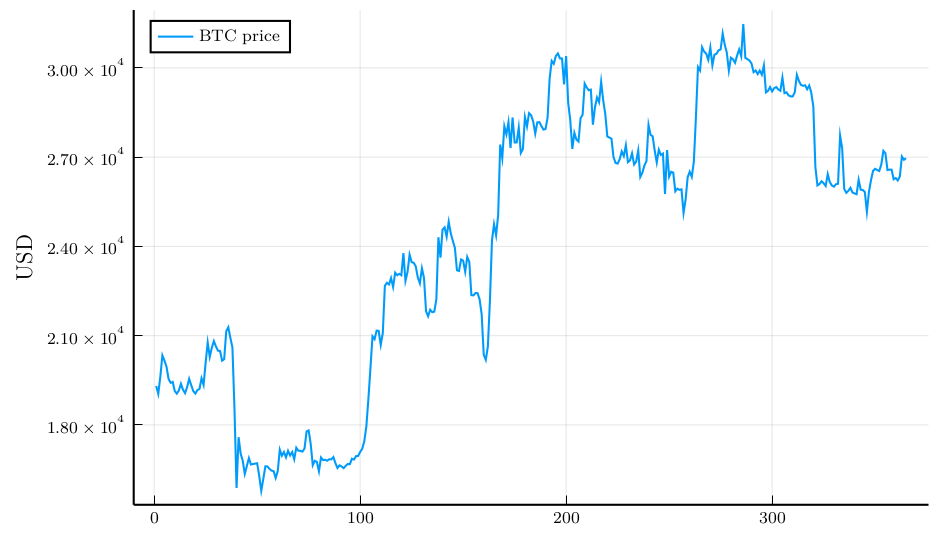

In [5]:
plot(y_data,label="BTC price",legend=:topleft)
ylabel!("USD")

## GCV model

In [193]:
@model function gcv_hgf(y)
    z2_prev ~ NormalMeanVariance(0.,50.)
    z1_prev ~ NormalMeanVariance(0.,50.)

    k ~ NormalMeanVariance(1.,0.1)
    w ~ NormalMeanVariance(0.,10)
    ζ ~ GammaShapeRate(0.01,0.01)
    for i=1:length(y)
        z2[i] ~ NormalMeanPrecision(z2_prev,ζ) #upper layer
        z1[i] ~ GCV(z1_prev, z2[i], k,w) ## lower layer
        y[i] ~ NormalMeanVariance(z1[i],0.01)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

@constraints function hgfconstraints() 
    q(z1, z2, z2_prev, z1_prev,w,k,ζ) = q(z1)q(z1_prev)q(z2)q(z2_prev)q(w)q(ζ)q(k)
end

@meta function hgfmeta()
    GCV() -> GCVMetadata(GaussHermiteCubature(31)) 
end

hgf_init = @initialization begin
    q(z1) = NormalMeanVariance(0,50)
    q(z2) = NormalMeanVariance(0,50)
    q(k) = NormalMeanVariance(1,0.1)
    q(w) = NormalMeanVariance(0,10)
    q(ζ) = GammaShapeRate(0.01,0.01)
end
;

In [194]:
GCV_infer = infer(
    model = gcv_hgf(),
    data = (y = y_data,),
    meta = hgfmeta(),
    constraints = hgfconstraints(),
    initialization = hgf_init,
    iterations = 300,
    returnvars = (z1 = KeepLast(), z2 = KeepLast(), w=KeepLast(),k=KeepLast(),ζ = KeepLast(),),
    free_energy = true
)

Inference results:
  Posteriors       | available for (w, z1, k, ζ, z2)
  Free Energy:     | Real[1.11424e13, 3.95375e11, 5.33521e10, 1.73796e9, 2.87116e8, 1.49421e8, 7.27157e7, 6.94292e7, 3.97016e7, 2830.78  …  2880.4, 2880.4, 2880.4, 2880.39, 2880.39, 2880.39, 2880.39, 2880.38, 2880.38, 2880.38]


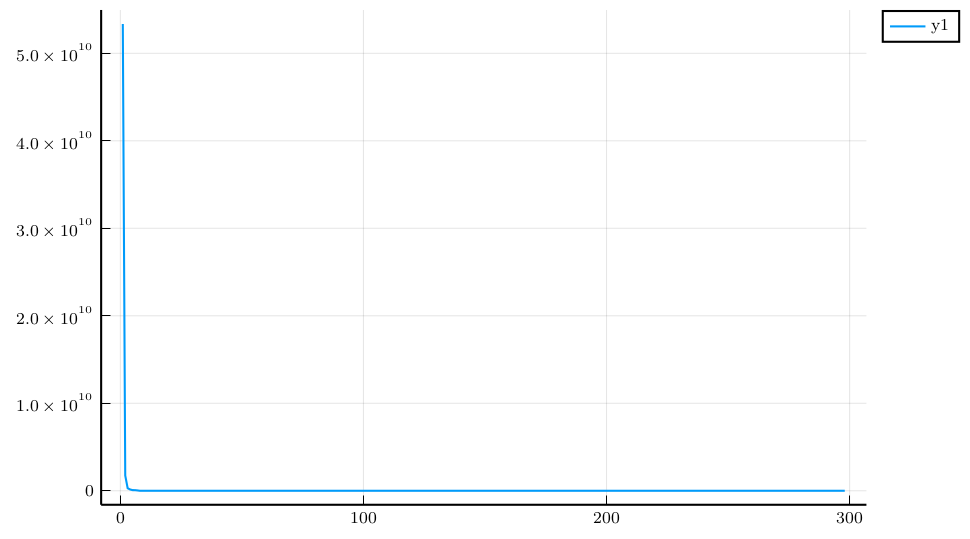

In [195]:
plot(GCV_infer.free_energy[3:end])

In [196]:
qz1_gcv = GCV_infer.posteriors[:z1]
qz2_gcv = GCV_infer.posteriors[:z2]
qw_gcv = GCV_infer.posteriors[:w]
qk_gcv = GCV_infer.posteriors[:k]
qζ_gcv = GCV_infer.posteriors[:ζ]
;

## SGP node

In [197]:
function sampling_approx_expectation(f,q, n_sample)
    samples = rand(q, n_sample)
    return mean(f.(samples))
end

sampling_approx_expectation (generic function with 1 method)

In [273]:
## Exponential node 
struct ExpNormal end

@node ExpNormal Stochastic [ y, x, z ]   ## f(y,x,z) = NormalMeanVariance(y| x, exp(z))

@rule ExpNormal(:y, Marginalisation) (q_x::Any, q_z::Any) = begin
    γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> 1 / (exp(z) + 1e-5))
    if isinf(γ1)
        γ1 = sampling_approx_expectation((z) -> 1 / (exp(z) + 1e-5),q_z, 1000) 
    end
    return NormalMeanPrecision(mean(q_x), γ1)
end

@rule ExpNormal(:x, Marginalisation) (q_y::Any, q_z::Any) = begin
    γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> 1 / (exp(z) + 1e-5))
    if isinf(γ1)
        γ1 = sampling_approx_expectation((z) -> 1 / (exp(z) + 1e-5),q_z, 1000) 
    end
    return NormalMeanPrecision(mean(q_y), γ1)
end

@rule ExpNormal(:z, Marginalisation) (q_y::Any, q_x::Any) = begin
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)

    log_backwardmess = (z) -> -0.5*z - 0.5 * (1/(exp(z) + 1e-5)) * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
    return ContinuousUnivariateLogPdf(log_backwardmess)
end


@average_energy ExpNormal (q_y::Any, q_x::Any, q_z::Any) = begin
    γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> 1 / (exp(z) + 1e-5))
    if isinf(γ1)
        γ1 = sampling_approx_expectation((z) -> 1 / (exp(z) + 1e-5),q_z, 1000) 
    end
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)
    μ_z = mean(q_z)
    return 0.5*log(2π) + 0.5*μ_z + 0.5* γ1 * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
end



In [199]:
@model function gp_HFG1(y, Kuu)
    z2_prev ~ NormalMeanVariance(0, 50.)
    z1_prev ~ NormalMeanVariance(0, 50.)
    v ~ MvNormalWeightedMeanPrecision(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.01,0.01)
    ζ ~ GammaShapeRate(0.01,0.01)

    for i=1:length(y)
        z2[i] ~ NormalMeanPrecision(z2_prev,ζ) 
        f[i] ~ GPTransition(z2[i],v,w) 
        z1[i] ~ ExpNormal(z1_prev, f[i])
        y[i] ~ NormalMeanVariance(z1[i], 0.01)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

In [295]:
Nu = 50; #number of inducing points 
Xu = range(-20,20;length=Nu);
kernel_gp   = 13.312 * with_lengthscale(Matern52Kernel(),9.572)
Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-7*I;
Kuu_inverse = inv(Kuu);

In [296]:
@meta function meta_gp_HFG1(method,Xu, Kuu_inverse, kernel)
    GPTransition() -> GPTransitionMeta(method,Xu,Kuu_inverse,nothing,kernel,nothing)
end

gp_constraint = @constraints begin
    q(z1,z2,z1_prev,z2_prev,v,w,f,ζ) = q(z1)q(z2)q(z1_prev)q(z2_prev)q(v)q(w)q(f)q(ζ)
    q(z1) = q(z1[begin])..q(z1[end])
    q(z2) = q(z2[begin])..q(z2[end])
end

gp_initialization = @initialization begin
    q(v) = MvNormalWeightedMeanPrecision(zeros(size(Kuu,1)), Kuu)
    q(f) = NormalMeanVariance(0,150)
    q(z1) = NormalMeanVariance(0,50.)
    q(z2) = NormalMeanVariance(0,10.)
    q(w) = GammaShapeRate(0.01,0.01)
    q(ζ) =  GammaShapeRate(0.01,0.01)
end
;

In [297]:
niter =300
infer_result = infer(
    model = gp_HFG1(Kuu = Kuu,),
    data = (y = y_data,),
    iterations = niter,
    constraints = gp_constraint,
    initialization = gp_initialization,
    meta = meta_gp_HFG1(ghcubature(21),Xu,Kuu_inverse,kernel_gp),
    returnvars = (z1 = KeepLast(),z2 = KeepLast(),v = KeepLast(), w = KeepLast(), ζ = KeepLast(),f = KeepLast(),),
    free_energy = true,
    showprogress = true
)


Progress: 100%|█████████████████████████████████████████| Time: 0:03:45


Inference results:
  Posteriors       | available for (f, w, z1, v, ζ, z2)
  Free Energy:     | Real[1.2547e6, 2.0664e6, 1.22867e6, 405599.0, 2942.23, 2935.96, 2934.74, 2934.67, 2934.9, 2935.19  …  2915.86, 2915.86, 2915.86, 2915.86, 2915.86, 2915.86, 2915.86, 2915.86, 2915.86, 2915.86]


In [298]:
qz1_sgp = infer_result.posteriors[:z1]
qz2_sgp = infer_result.posteriors[:z2]
qv_sgp = infer_result.posteriors[:v]
qw_sgp = infer_result.posteriors[:w]
qζ_sgp = infer_result.posteriors[:ζ]
qf_sgp = infer_result.posteriors[:f]
;

## Compare results

In [299]:
function gp_predict(x_test,qv,qw,meta)
    prediction = @call_rule GPTransition(:out, Marginalisation) (q_in=x_test,q_v = qv, q_w = qw, meta=meta)
    return prediction
end

function gcv_predict(upper_state,qk, qw)
    mz, vz = mean_var(upper_state)
    mk, vk = mean_var(qk)
    zk = NormalMeanVariance(mz * mk, mz^2 * vk + mk^2 * vz + vz * vk)
    return @call_rule typeof(+)(:out, Marginalisation) (m_in1=zk, m_in2 = qw)
end

gcv_predict (generic function with 1 method)

In [300]:
gp_predict_mean =[]
gp_predict_var =[]
for i=1:length(qz2_sgp)
    prediction = gp_predict(qz2_sgp[i],qv_sgp,qw_sgp,GPTransitionMeta(GenUnscented(),Xu,Kuu_inverse,nothing,kernel_gp,nothing))
    append!(gp_predict_mean,mean(prediction))
    append!(gp_predict_var,var(prediction)) 
end

gcv_predict_mean =[]
gcv_predict_var =[]
for i=1:length(qz2_gcv)
    prediction = gcv_predict(qz2_gcv[i],qk_gcv,qw_gcv)
    append!(gcv_predict_mean,mean(prediction))
    append!(gcv_predict_var,var(prediction)) 
end

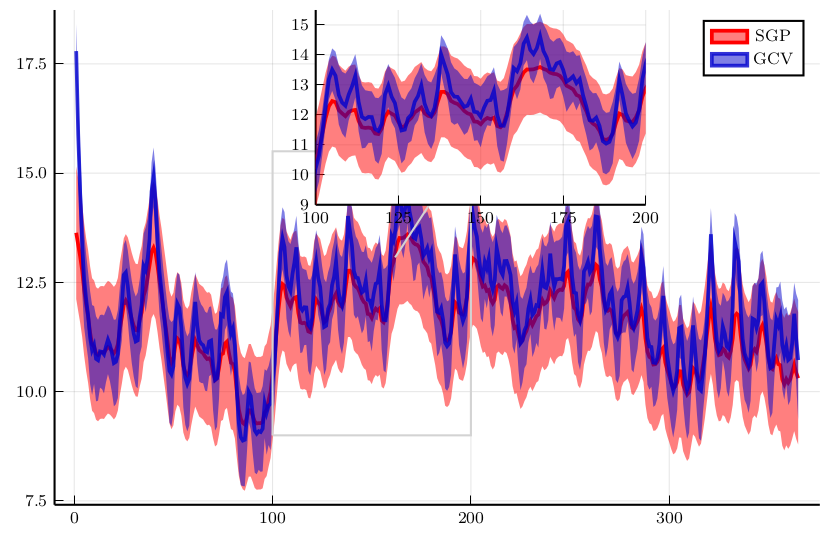

In [301]:
plot(gp_predict_mean, ribbon = sqrt.(gp_predict_var .+ 1e-7),
    lw=1.8,
    label = "SGP",
    color=:red,
    legend=:topright)
    
plot!(gcv_predict_mean, ribbon = sqrt.(gcv_predict_var .+ 1e-7),
    lw=1.8,
    label = "GCV",
    alpha = 0.8,
    color = :mediumblue)

lens!([100, 200], [9, 15.5], inset = (1, bbox(0.3, 0., 0.5, 0.5)))

In [147]:
savefig("texfiles/HGF_stateresult.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_stateresult.svg"

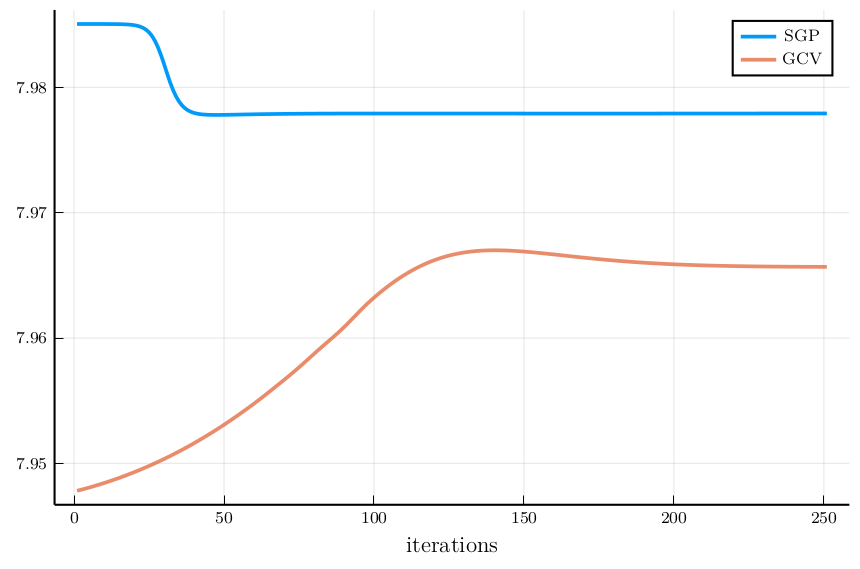

In [302]:
plot(log.(infer_result.free_energy)[50:end], label="SGP",lw=1.8, legend=:topright)
plot!(log.(GCV_infer.free_energy)[50:end],label="GCV",lw=1.8, alpha=0.8)
xlabel!("iterations")

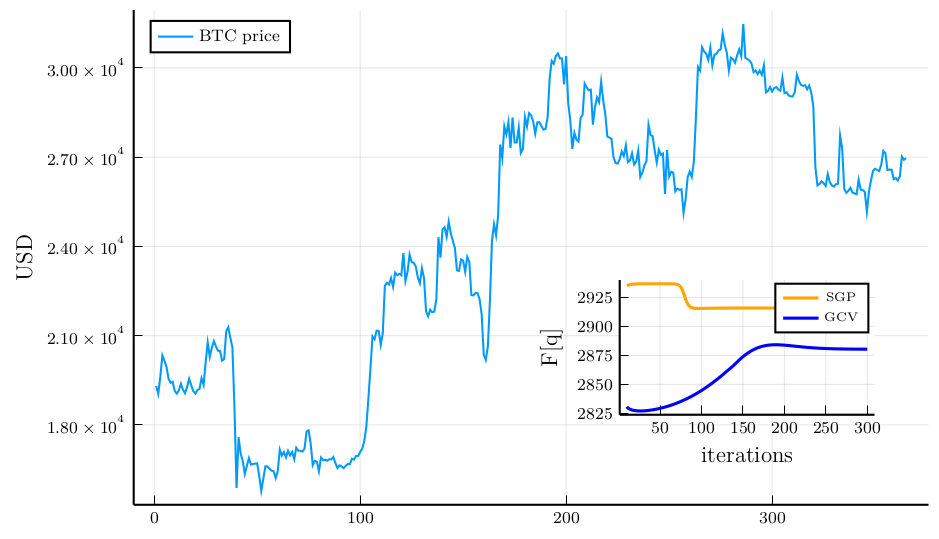

In [303]:
plot(y_data,label="BTC price",legend=:topleft)
ylabel!("USD")

plot!([collect(10:niter),collect(10:niter)],
    [infer_result.free_energy[10:end], GCV_infer.free_energy[10:end]], 
    label=["SGP" "GCV"],
    color=[:orange :blue],
    lw= [1.5 1.5],
    legend=:topright,
    legend_font_pointsize=6,
    inset = (1, bbox(0.06, 0.15, 0.4, 0.4, :bottom, :right)),
    xlabel="iterations",
    ylabel="F[q]",
    subplot = 2)

In [304]:
savefig("texfiles/HGF_real_data.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_real_data.svg"

## Optimize hyperparameters

In [293]:
kernel_gp_param = (θ) -> θ[1]* with_lengthscale(Matern52Kernel(),θ[2]); 
kernelmatrix_param = (θ) -> kernelmatrix(kernel_gp_param(θ),Xu,Xu) + 1e-7*I;
function my_free_energy(θ)
    @show θ
    my_Kuu = kernelmatrix_param(θ)
    my_Kuu_inverse = inv(my_Kuu)
    my_kernel = kernel_gp_param(θ)

    init = @initialization begin
        q(v) = MvNormalWeightedMeanPrecision(zeros(size(my_Kuu,1)), my_Kuu)
        q(f) = NormalMeanVariance(0,150)
        q(z1) = NormalMeanVariance(0,50.)
        q(z2) = NormalMeanVariance(0,10.)
        q(w) = GammaShapeRate(0.01,0.01)
        q(ζ) =  GammaShapeRate(0.01,0.01)
    end

    infer_tmp = infer(
        model = gp_HFG1(Kuu = my_Kuu,),
        data = (y = y_data,),
        iterations = 75,
        initialization = init,
        constraints = gp_constraint,
        meta = meta_gp_HFG1(ghcubature(21),Xu,my_Kuu_inverse,my_kernel),
        returnvars = (z1 = KeepLast(),z2 = KeepLast(),v = KeepLast(), w = KeepLast(), ζ = KeepLast(),f = KeepLast(),),
        free_energy = true
    )
    return infer_tmp.free_energy[end]
end

function learn_params(θ,iter)
    lower = [7,7]
    upper = [15,15]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iter))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [294]:
#this will take ~21min
θ_init = [9., 8.]
θ_optimal = learn_params(θ_init,1)

θ = [9.0, 8.0]
θ = [13.525, 8.0]
θ = [9.0, 12.025]
θ = [9.000054499090071, 8.0]
θ = [8.999945500909929, 8.0]
θ = [9.0, 8.000048443635619]
θ = [9.0, 7.999951556364381]
θ = [9.0, 12.025]
θ = [10.13125, 10.0125]
θ = [11.828125, 9.00625]
θ = [11.828125, 9.00625]
θ = [11.828125, 13.534374999999999]
θ = [14.79765625, 10.138281249999999]
θ = [13.312890625, 9.572265625]
θ = [13.312890625, 9.572265625]
θ = [13.312890625, 14.3833984375]
θ = [13.312890625, 11.97783203125]
θ = [13.312890625, 10.775048828125]
θ = [13.312890625, 9.572265625]


2-element Vector{Float64}:
 13.312890625
  9.572265625

## Scrap

In [ ]:
# 2.1921875, 12.500781250000001 #this is amazing
# mean_gp = (x) -> 0
# θ = [[4.5625, 3.5]]
# 6.86875, 3.5
# 6.676562500000002, 6.643750000000001
# 6.643750000000002, 2.1812500000000004
# 6.228125000000002, 7.759375000000002
# 8.778613281250003, 9.711718750000003
# 10.433978271484378, 8.491503906250003 (good)
## GP predict
# function predict_SGP(prev_state_upper,prev_state, qv, qw,qζ, meta)
#     z2_current = @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ = prev_state_upper, q_τ = qζ)
#     f_current = @call_rule GPTransition(:out, Marginalisation) (q_in = z2_current,q_v = qv, q_w=qw, meta=meta)
#     z1_current = @call_rule ExpNormal(:y, Marginalisation) (q_x=prev_state, q_z = f_current)
#     return z1_current, z2_current
# end

# ## GHV predict 
# function predict_GCV(prev_state_upper,prev_state, qk, qw,qζ, gcvmeta)
#     z2_current = @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ = prev_state_upper, q_τ = qζ)
#     z1_current = @call_rule GCV(:y, Marginalisation) (m_x=prev_state, q_z = z2_current, q_κ = qk, q_ω=qw, meta=gcvmeta)
#     @show mean(prev_state_upper)
#     @show mean(z2_current)
#     @show mean(qζ)
#     @show mean(prev_state)
#     return z1_current, z2_current
# end

# SGP_predict = []
# SGP_var_predict = []
# prev_z2 = qz2_sgp[end]
# prev_z1 = qz1_sgp[end]
# for i=1:length(y_data_test)
#     prediction_z1, prediction_z2 = predict_SGP(prev_z2,prev_z1,qv_sgp,qw_sgp,qζ_sgp,GPTransitionMeta(Xu,Kuu_inverse,nothing,kernel_gp,nothing))
#     append!(SGP_predict,mean(prediction_z1))
#     append!(SGP_var_predict,var(prediction_z1)) 
#     prev_z2 = prediction_z2
#     prev_z1 = prediction_z1
# end
# ## by UT
# GCV_predict = []
# GCV_var_predict = []
# GCV_prev_z2 = qz2_gcv[end]
# GCV_prev_z1 = qz1_gcv[end]
# for i=1:length(y_data_test)
#     prediction_z1,prediction_z2 = predict_GCV(GCV_prev_z2,GCV_prev_z1, PointMass(1), PointMass(0),qζ, GCVMetadata(GaussHermiteCubature(31)) )
#     append!(GCV_predict,mean(prediction_z1))
#     append!(GCV_var_predict,var(prediction_z1)) 
#     GCV_prev_z2 = prediction_z2
#     GCV_prev_z1 = prediction_z1
# end
# plot(GCV_predict, label="GCV",lw=1.5, legend=:bottomright)
# # plot!(SGP_predict,ribbon=sqrt.(SGP_var_predict),label="SGP node", lw=1.5)
# scatter!(vcat(y_data_train[end],y_data_test),label="true states")
# xlabel!("t")
# title!("Predictive states")


# @rule ExpNormal(:y, Marginalisation) (q_x::Any, q_z::Any) = begin
#     γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> exp(z))
#     if isinf(γ1)
#         γ1 = clamp(sampling_approx_expectation((z) -> exp(z), q_z, 1000),1e-2,1e2) 
#         # @show γ1
#     end 
#     return NormalMeanPrecision(mean(q_x), γ1)
# end

# @rule ExpNormal(:x, Marginalisation) (q_y::Any, q_z::Any) = begin
#     γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> exp(z))
#     if isinf(γ1)
#         γ1 = clamp(sampling_approx_expectation((z) -> exp(z), q_z, 1000),1e-2,1e2) 
#     end 
#     return NormalMeanPrecision(mean(q_y), γ1)
# end

# @rule ExpNormal(:z, Marginalisation) (q_y::Any, q_x::Any) = begin
#     μ_y, v_y = mean_var(q_y)
#     μ_x, v_x = mean_var(q_x)

#     log_backwardmess = (z) -> 0.5*z - 0.5 * exp(z) * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
#     return ContinuousUnivariateLogPdf(log_backwardmess)
# end


# @average_energy ExpNormal (q_y::Any, q_x::Any, q_z::Any) = begin
#     μ_y, v_y = mean_var(q_y)
#     μ_x, v_x = mean_var(q_x)
#     μ_z = mean(q_z)

#     γ1 = approximate_expectation(GenUnscented() ,q_z, (z) -> exp(z))
#     if isinf(γ1)
#         γ1 = clamp(sampling_approx_expectation((z) -> exp(z), q_z, 1000),1e-2,1e2) 
#         # @show γ1
#         # @show mean(q_z)
#         # @show 0.5* γ1 * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
#         # throw(Error())
#     end 
#     return 0.5*log(2π) - 0.5*μ_z + 0.5* γ1 * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
# end
